[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/044_cnn_transfer_learning/cnn_transfer_learning.ipynb)

# Transfer Learning en Redes Convolucionales

En posts anteriores hemos introducido la arquitectura de `red neuronal convolucional` y también hemos presentado varias arquitecturas famosas que han demostrado buenas prestaciones en multitud de tareas. Estas redes están formadas muchas capas convolucionales, algunas con más de 100 capas, lo cual significa que tienen muchos parámetros y entrenarlas desde cero puedes ser costoso. Sin embargo, existe una técnica que nos permite obtener buenos modelos con menores requisitos: el *transfer learning*. Ya hemos hablado anteriormente de esta técnica, en el contexto de modelos de lenguaje, pero la idea es la misma: utilizaremos el máximo número de capas de una red ya entrenada en otro dataset, y simplemente entrenaremos las nuevas capas que necesitemos para nuestra tarea concreta.

![](https://pennylane.ai/qml/_images/transfer_learning_general.png)

En este post vamos a ver cómo podemos utilizar una red neuronal pre-entrada en Imagenet, y adaptarla para una nueva tarea de clasificación con un pequeño dataset.

## El dataset

Nuestro objetivo será el de entrenar un clasificador de flores. Podemos descargar las imágenes de la siguiente url.

In [2]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=b74d63fb1a2698afb89620b2bc600c6450d476ac0c103cd2e473362bcdd7e4d6
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
import wget 

wget.download('https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/flowers.zip')

'flowers.zip'

In [4]:
import zipfile

with zipfile.ZipFile('flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Una vez extraído el dataset, podemos ver que tenemos 5 clases de flores diferentes, distribuidas en 5 carpetas diferentes. Cada carpeta contiene varios ejemplos de flores de la categoría en cuestión.

In [5]:
import os 

PATH = 'flowers'

classes = os.listdir(PATH)
classes

['sunflower', 'dandelion', 'tulip', 'daisy', 'rose']

In [6]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: sunflower. Imágenes: 734
Categoría: dandelion. Imágenes: 1055
Categoría: tulip. Imágenes: 984
Categoría: daisy. Imágenes: 769
Categoría: rose. Imágenes: 784


Podemos visualizar algunas imágenes en el dataset.

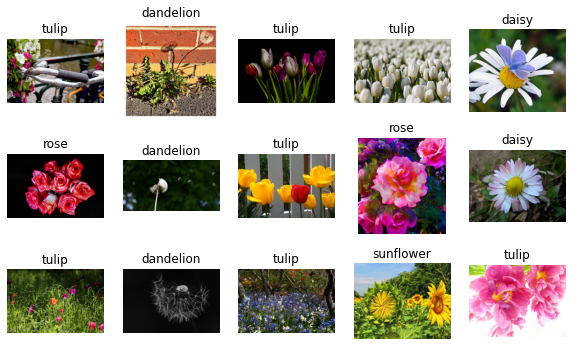

In [7]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

Vamos a crear también un subconjunto de test para poder comparar varios modelos.

In [8]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(3458, 865)

Y por último creamos nuestros objetos `Dataset` y `DataLoader` para poder darle las imágenes a nuestros modelos.

In [9]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

Nos aseguraremos que todas las imágenes del dataset tengan las mismas dimensiones: 224x224 píxeles.

In [10]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(3458, 865)

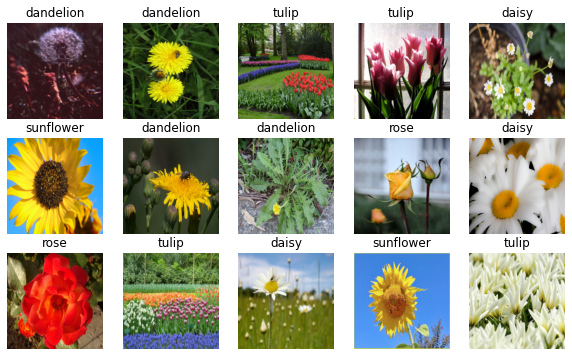

In [11]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [12]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

## El Modelo

Vamos a escoger la arquitectura `resnet`, de la que ya hablamos en el post anterior, para hacer nuestro clasificador. De este modelo usarmos todas las capas excepto la última, la cual sustituiremos por una nueva capa lineal para llevar a cabo la clasificación en 5 clases.

In [13]:
import torchvision

resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [15]:
model = Model()
outputs = model(torch.randn(64, 3, 224, 224))
outputs.shape

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 5])

In [16]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

### Entrenando desde cero

En primer lugar vamos a entrenar nuestro modelo desde cero para ver qué métricas podemos obtener.

In [ ]:
model = Model()
fit(model, dataloader, epochs=15)

  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 1/15 loss 1.38035 val_loss 6.62556 acc 0.41136 val_acc 0.18881


  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 2/15 loss 1.14277 val_loss 2.67887 acc 0.53977 val_acc 0.32263


  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 3/15 loss 1.03443 val_loss 2.11420 acc 0.57926 val_acc 0.35868


  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 4/15 loss 0.96419 val_loss 3.34853 acc 0.61534 val_acc 0.36685


  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 5/15 loss 0.89560 val_loss 2.53937 acc 0.65142 val_acc 0.35537


  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 6/15 loss 0.85376 val_loss 7.21106 acc 0.67159 val_acc 0.23745


  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 7/15 loss 0.82979 val_loss 2.87065 acc 0.67812 val_acc 0.28967


  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 8/15 loss 0.84172 val_loss 10.45654 acc 0.66989 val_acc 0.23889


  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 9/15 loss 0.77135 val_loss 3.13403 acc 0.68920 val_acc 0.40119


  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 10/15 loss 0.76101 val_loss 4.79418 acc 0.70426 val_acc 0.28006


  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 11/15 loss 0.69798 val_loss 1.26967 acc 0.73153 val_acc 0.52445


  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 12/15 loss 0.66299 val_loss 3.41976 acc 0.74205 val_acc 0.29100


  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 13/15 loss 0.65538 val_loss 2.28475 acc 0.75767 val_acc 0.42954


  0%|                                           | 0/55 [00:00<?, ?it/s]

Epoch 14/15 loss 0.60125 val_loss 3.14427 acc 0.77926 val_acc 0.25994


val_loss 6.78454 val_acc 0.27369: 100%|██| 4/4 [00:03<00:00,  1.15it/s]

Epoch 15/15 loss 0.60031 val_loss 6.78454 acc 0.79432 val_acc 0.27369


Como puedes ver es complicado conseguir buenas métricas ya que nuestro dataset es muy pequeño.

## Transfer Learning

Ahora vamos a entrenar el mismo caso pero, en este caso, utilizando los pesos pre-entrenados de `resnet`.

In [17]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

val_loss 0.99482 val_acc 0.56468: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Epoch 1/5 loss 1.04701 val_loss 0.99482 acc 0.63977 val_acc 0.56468


val_loss 1.37311 val_acc 0.41263: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 2/5 loss 0.64977 val_loss 1.37311 acc 0.80710 val_acc 0.41263


val_loss 0.67123 val_acc 0.75081: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Epoch 3/5 loss 0.56134 val_loss 0.67123 acc 0.82955 val_acc 0.75081


val_loss 0.68754 val_acc 0.75658: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 4/5 loss 0.48718 val_loss 0.68754 acc 0.84716 val_acc 0.75658


val_loss 0.58569 val_acc 0.79619: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

Epoch 5/5 loss 0.45519 val_loss 0.58569 acc 0.86023 val_acc 0.79619


Como puedes ver no sólo obtenemos un mejor modelo en menos *epochs* sino que además cada *epoch* tarda menos en completarse. Esto es debido a que, al no estar entrenando gran parte de la red, los requisitos computacionales se reducen considerablemente. Mejores modelos y entrenados más rápido.

## Fine Tuning

Todavía podemos mejorar un poco más si, además de utilizar los pesos descargados de Imagenet en `resnet`, entrenamos también la red completa.

In [19]:
model = Model(pretrained=True, freeze=False)
fit(model, dataloader)

val_loss 1.10246 val_acc 0.55140: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Epoch 1/5 loss 0.80439 val_loss 1.10246 acc 0.73523 val_acc 0.55140


val_loss 0.58642 val_acc 0.76725: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Epoch 2/5 loss 0.36218 val_loss 0.58642 acc 0.88438 val_acc 0.76725


val_loss 0.29765 val_acc 0.90126: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 3/5 loss 0.23651 val_loss 0.29765 acc 0.93267 val_acc 0.90126


val_loss 0.40934 val_acc 0.86751: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 4/5 loss 0.18665 val_loss 0.40934 acc 0.93949 val_acc 0.86751


val_loss 0.36607 val_acc 0.87622: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

Epoch 5/5 loss 0.15787 val_loss 0.36607 acc 0.95000 val_acc 0.87622


Es común entrenar primero el modelo sin entrenar la red pre-entrenada durante varias epochs y después seguir entrenando, pero permitiendo ahora la actualización de pesos también en la red pre-entrenada (usualmente con un *learning rate* más pequeño).

In [20]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-4)

val_loss 1.08559 val_acc 0.50544: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Epoch 1/5 loss 1.03473 val_loss 1.08559 acc 0.66193 val_acc 0.50544


val_loss 0.80613 val_acc 0.70881: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Epoch 2/5 loss 0.66036 val_loss 0.80613 acc 0.79006 val_acc 0.70881


val_loss 0.63072 val_acc 0.75260: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 3/5 loss 0.53648 val_loss 0.63072 acc 0.83864 val_acc 0.75260


val_loss 0.58669 val_acc 0.79611: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 4/5 loss 0.48007 val_loss 0.58669 acc 0.85625 val_acc 0.79611


val_loss 1.15962 val_acc 0.51086: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 5/5 loss 0.47848 val_loss 1.15962 acc 0.83722 val_acc 0.51086


val_loss 0.93646 val_acc 0.61566: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 1/5 loss 1.08558 val_loss 0.93646 acc 0.52955 val_acc 0.61566


val_loss 0.67422 val_acc 0.72924: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 2/5 loss 0.76362 val_loss 0.67422 acc 0.68125 val_acc 0.72924


val_loss 0.61546 val_acc 0.76467: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Epoch 3/5 loss 0.58712 val_loss 0.61546 acc 0.75057 val_acc 0.76467


val_loss 0.52316 val_acc 0.81627: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 4/5 loss 0.53124 val_loss 0.52316 acc 0.80852 val_acc 0.81627


val_loss 0.48516 val_acc 0.82630: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

Epoch 5/5 loss 0.45504 val_loss 0.48516 acc 0.85227 val_acc 0.82630


Otra alternativa de *fine tuning* es la de entrenar el modelo con diferentes *learning rates*, uno para la red pre-entrenada y otro para las capas nuevas.

In [21]:
optimizer = torch.optim.Adam([
    {'params': model.resnet.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])

ONNX


In [22]:
x = torch.rand(64, 3, 224, 224)
y = model.cpu()(x)

# exportamos el modelo
torch.onnx.export(model,                     # el modelo
                  x,                         # un ejemplo del input
                  "model.onnx",              # el nombre del archivo para guardar el modelo
                  export_params=True,        # guardar los pesos de la red
                  opset_version=10,          # versión de ONNX
                  do_constant_folding=True,  # optimizaciones
                  input_names = ['input'],   # nombre de los inputs
                  output_names = ['output'], # nombre de los outputs
                  dynamic_axes={'input' : {0 : 'batch_size'},    # ejes con longitud variable (para poder usar diferentes tamaños de batch)
                                'output' : {0 : 'batch_size'}})

## Resumen

En este post hemos visto como podemos llevar a cabo *transfer learning* con redes convolucionales. Aplicar esta técnica nos permitirá obtener mejores modelos con menos requisitos computacionales y con datasets reducidos. Podemos descargar una red pre-entrenada con otro dataset (idealmente, un dataset similar al nuestro) y aprovechar el máximo número de capas. Podemos *congelar* la red pre-entrenada, de manera que no se actualicen sus pesos durante el entrenamiento, y utilizarla solo como extractor de características que las nuevas capas (las cuales si entrenamos) pueden aprovechar. Aún así, hacer *fine tuning* (seguir entrenando la red pre-entrenada) puede dar como resultado un mejor modelo. El *transfer learning* es una técnica muy potente que siempre que podamos podemos aprovechar para reducir los requisitos computacionales de nuestros modelos.